In [1]:
import pyrosetta
import dask.bag
import dask.distributed

In [2]:
import pandas
import seaborn
from matplotlib import pylab

In [3]:
from pyrosetta.distributed.tasks.score import ScorePoseTask
from pyrosetta.distributed.io import pose_from_pdbstring
from pyrosetta.distributed.packed_pose import to_dict

In [4]:
import zipfile

In [5]:
cluster = dask.distributed.LocalCluster()
client = dask.distributed.Client(cluster)

In [6]:
def load_source(decoy):
    src_pdb = zipfile.ZipFile(library).open(decoy).read()
    p = pose_from_pdbstring(src_pdb)
    
    cys_locations=[i for i, c in enumerate(p.pose.sequence()) if c == "C"]
    p = p.update_scores(
        library=library,
        decoy=decoy,
        sequence=p.pose.sequence(),
        num_res = len(p.pose.sequence()),
        num_cys=len(cys_locations),
        cys_locations=",".join(map(str, cys_locations))
    )

    return p

In [7]:
library = "EHEE_library.zip"
decoy_names = [f.filename for f in zipfile.ZipFile(library).filelist if f.filename.endswith(".pdb")]

In [8]:
decoys = dask.bag.from_sequence(decoy_names).map(load_source).map(ScorePoseTask()).persist()

In [9]:
result_frame = pandas.DataFrame.from_records(decoys.map(to_dict).compute()).sort_values("total_score")

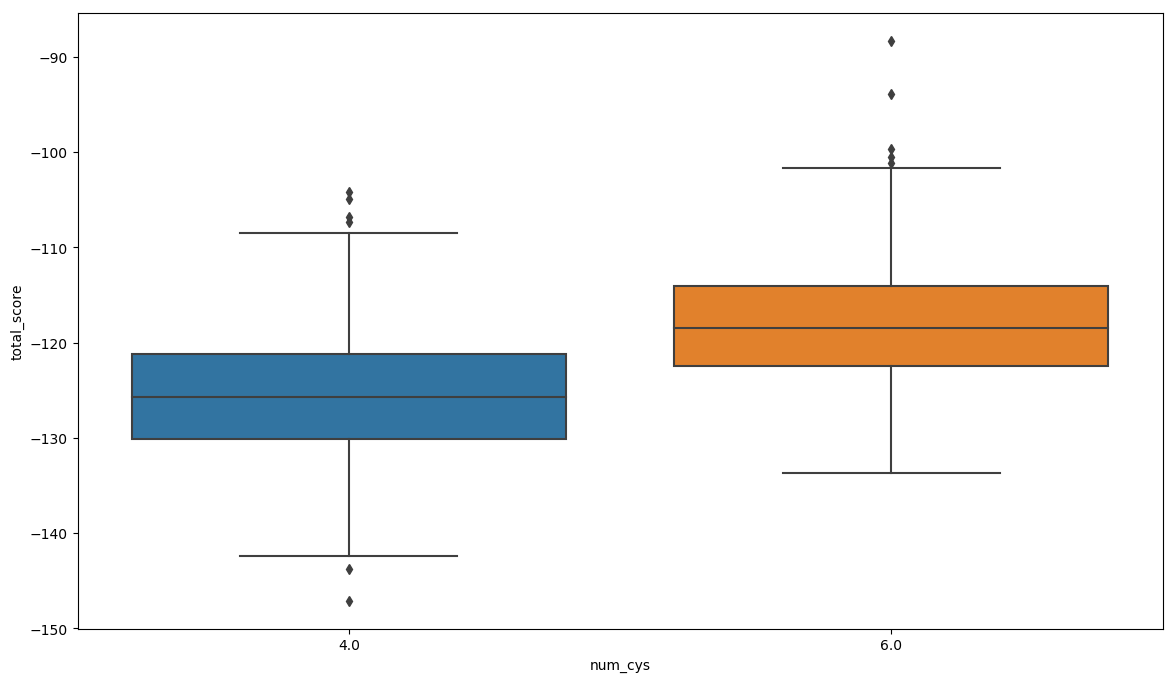

In [10]:
seaborn.boxplot(x="num_cys", y="total_score", data=result_frame)

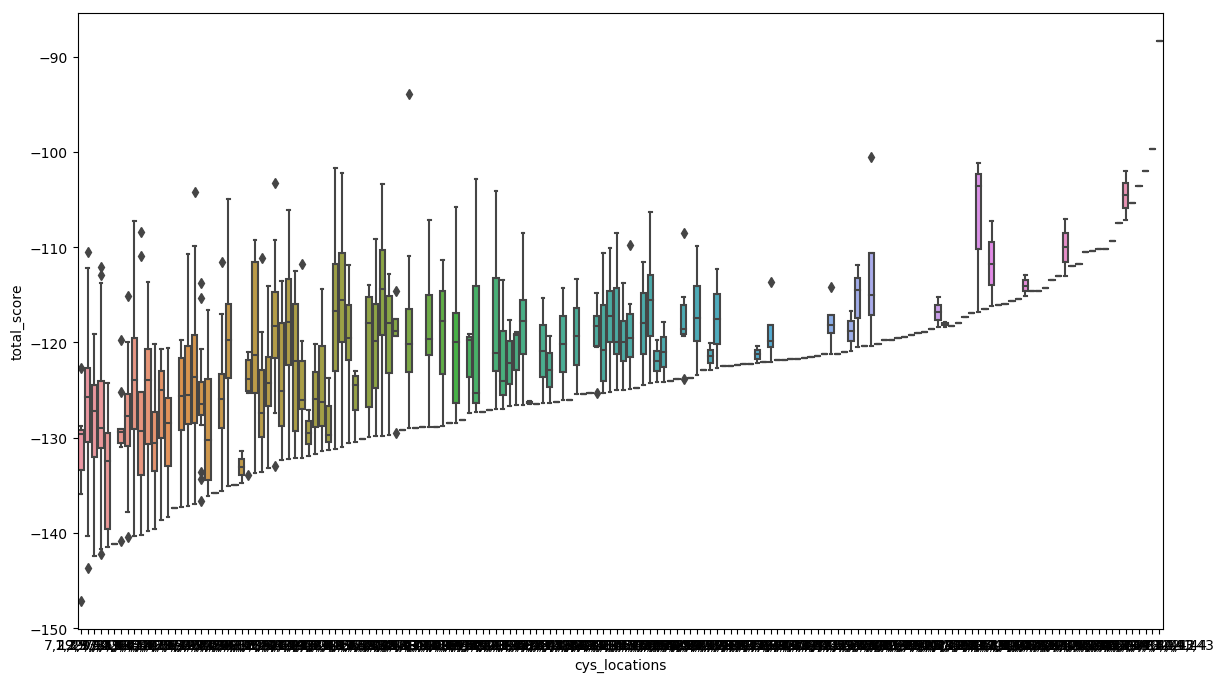

In [11]:
seaborn.boxplot(x="cys_locations", y="total_score", data=result_frame)

In [12]:
best_by_location = to_dict(result_frame.groupby("cys_locations").head(1).reset_index(drop=True))

In [13]:
with open("EHEE.best_by_location.fasta", "w") as out:
    for entry in best_by_location:
        print(f">{entry['decoy']}", file=out)
        print(entry['sequence'], file=out)

In [14]:
!head EHEE.best_by_location.fasta

>30652025_EHEE_254_0001.pdb
GDYQLHTCNTSEEELKKLTETLRRRLQTECKLERHGDCYTITCHV
>30887334_EHEE_738_0001.pdb
GCKTLTFCGYDDEQAKKIQKDISKTVQRPVEVHKHGSCWEFHVCV
>30856927_EHEE_395_0001.pdb
GCTTWEFHNVDPNEVKKALRELSEKTGAECHLEQHGNTFHITCCV
>30884953_EHEE_269_0001_0004.pdb
GQKCVTFCGQDPREVKKIAEEIARRLQVPYEIRRHGSCITVCFKV
>30696637_EHEE_467_0001_0002.pdb
GTKTFTYDGVDPTEVDKSRERLEKELKTRCELECRGNQCHIHCHV
